In [32]:
import astropy
import astropy.units as u
import lumos
import lumos.brdf
import lumos.brdf.library as brdf_library
import lumos.brdf.tools
import lumos.calculator
import lumos.conversions
import lumos.functions
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import EarthLocation
from lumos.brdf.library import BINOMIAL, LAMBERTIAN, PHONG
from lumos.geometry import Surface

from analysis import calculator, streakfunctions
from gen2_starlink import satellitemodels


# Setup and calulating brightness

In [33]:
# This cell only loads the streaks that are calculated during summer.
# The script streaks.py can also calculate streaks during the entire year. The usage
# section of streaks.py has information on how to make it calculate all the streaks.
# To save time, loading only a few summers instead of all 10 years will be better.


streaks = pd.DataFrame()
for year in range(3):
    scheduler = pd.read_csv(f"../data/results/year_{year}_streaks_summer_550km.csv")
    streaks = pd.concat([streaks, scheduler])
    streaks = streaks.reset_index(drop=True)
streaks

,id,alts,azs,heights,times,tel_ra,tel_dec,tel_alt,tel_az,ins,hours,night,tel_index
0,17984.0,53.867765,18.686207,554284.143963,60980.137140,26.997244,-5.111235,63.624418,18.267467,0.0,0.0,184.0,116470.0
1,17984.0,56.683616,19.440868,554378.583102,60980.137198,26.997244,-5.111235,63.630069,18.222376,0.0,0.0,184.0,116470.0
2,17984.0,59.654152,20.377200,554473.744160,60980.137255,26.997244,-5.111235,63.635705,18.177268,0.0,0.0,184.0,116470.0
3,17984.0,62.775901,21.568064,554569.615653,60980.137313,26.997244,-5.111235,63.641328,18.132142,1.0,0.0,184.0,116470.0
4,12972.0,61.709756,8.316927,554495.807893,60980.137140,26.997244,-5.111235,63.624418,18.267467,0.0,0.0,184.0,116470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338531,27933.0,54.750529,222.501670,556024.466203,61802.123942,60.059015,-48.816332,51.741653,228.244950,0.0,23.0,1006.0,621770.0
338532,28165.0,49.194478,236.868710,555933.224947,61802.124185,60.059015,-48.816332,51.685100,228.264690,0.0,23.0,1006.0,621771.0
338533,28165.0,50.973419,233.879052,555947.650770,61802.124243,60.059015,-48.816332,51.671632,228.269367,0.0,23.0,1006.0,621771.0
338534,28165.0,52.735838,230.508487,555961.729006,61802.124301,60.059015,-48.816332,51.658163,228.274035,1.0,23.0,1006.0,621771.0


In [34]:
times = astropy.time.Time(streaks["times"], format='mjd')
chile = astropy.coordinates.EarthLocation(lon = -70.7494* u.deg, lat = -30.2444 * u.deg,
    height= 2650.0*u.m)

x, y, z = streakfunctions.altaz_to_image(streaks["alts"], streaks["azs"], streaks["tel_alt"],\
    streaks["tel_az"])

In [35]:
# Calculate the point on streak that is the closest to the telscope's pointing direction
# And get relevant information about the satellite at that point.
xs = np.array(x)
ys = np.array(y)

c_xs = np.zeros(int(len(xs)/4))
c_ys = np.zeros(int(len(xs)/4))
c_ts = np.zeros(int(len(xs)/4))
c_talts = np.zeros(int(len(xs)/4))
c_tazs = np.zeros(int(len(xs)/4))


for i in range(int(len(xs)/4)):
    c_x, c_y, c_t, c_talt, c_taz = streakfunctions.closest(xs[i*4:i*4+4],ys[i*4:i*4+4],
        streaks["tel_alt"][i*4:i*4+4],streaks["tel_az"][i*4:i*4+4])
    c_xs[i] = c_x
    c_ys[i] = c_y
    c_ts[i] = c_t
    c_talts[i] = c_talt
    c_tazs[i] = c_taz

c_zs = np.sqrt(1-(c_xs**2 + c_ys**2))
c_rs = np.sqrt(c_xs**2 + c_ys**2)
c_ins = np.zeros(len(c_rs))
c_ins[np.arcsin(c_rs) < np.deg2rad(1.75)] = 1

c_sat_alts, c_sat_azs = streakfunctions.image_to_altaz(c_xs, c_ys, c_zs, c_talts,
    c_tazs)

c_times = np.zeros(len(c_ins))
for i in range(len(c_ins)):
    c_times[i] = (astropy.time.Time(streaks["times"][i*4], format="mjd")+c_ts[i]*u.second).mjd

nights = np.zeros(len(c_sat_alts))
hours = np.zeros(len(c_sat_alts))
tel_indices = np.zeros(int(len(xs)/4))

for i in range(len(c_sat_alts)):
    nights[i] = streaks["night"][i*4]
    hours[i] = streaks["hours"][i*4]
    tel_indices[i] = streaks["tel_index"][i*4]


In [36]:
# calculate sun position at each observation
t = astropy.time.Time(c_times, format="mjd")
sun_alt, sun_az = lumos.calculator.get_sun_alt_az(t, chile)
t = np.delete(t, np.where(sun_alt > 0)[0])
sun_az = np.delete(sun_az, np.where(sun_alt > 0)[0])
sun_alt = np.delete(sun_alt, np.where(sun_alt > 0)[0])

In [55]:
# Create a pandas database called "closests" containing information about each streak
# when it is the closest to the center of the telescope's focal plane.

closests = pd.DataFrame()
closests["xs"] = c_xs
closests["ys"] = c_ys
closests["zs"] = c_zs
closests["tel_alt"] = c_talts
closests["tel_az"] = c_tazs
closests["c_ins"] = c_ins
closests["sun_alt"] = sun_alt
closests["sun_az"] = sun_az
closests["heights"] = np.ones(len(c_sat_alts))*550000
_, _, _, angle_past_terminator = calculator.get_brightness_coords(
    c_sat_alts, c_sat_azs,closests["heights"], closests["sun_alt"], closests["sun_az"])
closests["aoi"] = np.rad2deg(angle_past_terminator)
closests["alts"] = c_sat_alts
closests["azs"] = c_sat_azs
closests["times"] = c_times
closests["night"] = nights
closests["hours"] = hours
closests["tel_index"] = tel_indices

closests = closests.loc[closests["c_ins"] == 1]
closests = closests.reset_index(drop=True)
closests

,xs,ys,zs,tel_alt,tel_az,c_ins,sun_alt,sun_az,heights,aoi,alts,azs,times,night,hours,tel_index
0,0.012729,0.002162,0.999917,63.630069,18.222376,1.0,-42.289320,202.832678,550000.0,44.586961,62.900464,18.494340,60980.137224,184.0,0.0,116470.0
1,-0.019806,0.015070,0.999690,53.091645,228.630274,1.0,-45.162452,175.869864,550000.0,43.226262,54.217599,230.107127,60980.193483,184.0,1.0,116591.0
2,-0.005030,0.010408,0.999933,76.479433,278.176266,1.0,-44.204221,193.820214,550000.0,44.137906,76.754451,280.779828,60980.156833,184.0,0.0,116512.0
3,0.004272,-0.013517,0.999900,76.479433,278.176266,1.0,-44.204203,193.820332,550000.0,44.021777,76.213282,274.924577,60980.156832,184.0,0.0,116512.0
4,0.008111,-0.009991,0.999917,52.831067,37.052418,1.0,-43.192797,199.178128,550000.0,46.465673,52.362601,36.114959,60980.145349,184.0,0.0,116488.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75729,0.018890,-0.008071,0.999789,55.426611,227.709343,1.0,-33.099172,217.811787,550000.0,29.937107,54.341599,226.916036,61802.115478,1006.0,23.0,621756.0
75730,-0.000927,0.005160,0.999986,55.317090,227.767175,1.0,-33.182775,217.661879,550000.0,30.148337,55.369123,228.287445,61802.115916,1006.0,23.0,621757.0
75731,-0.001117,-0.009300,0.999956,55.303727,227.774176,1.0,-33.197505,217.635378,550000.0,30.149746,55.364151,226.836581,61802.115994,1006.0,23.0,621757.0
75732,0.006499,-0.008018,0.999947,51.768577,228.235496,1.0,-34.643730,214.888918,550000.0,31.179365,51.393871,227.499231,61802.123846,1006.0,23.0,621770.0


In [56]:
# Split satellites into two groups based on the angle of incidence. The geometry of the
# satellites reflecting light shows that the angle of incidence and angle past
# terminator are the same. The satellites that are closer to the terminator are more
# suspectible to the effect of earth shine by being closer to illuminated land. We
# calculate the added brightness from earthshine for satellites that have an aoi <= 10.

lowsats = closests.loc[closests["aoi"] <= 10].copy()
highsats = closests.loc[closests["aoi"] > 10].copy()

In [39]:
# Setting up the satellite model surfaces and earth_brdf.
surfaces = satellitemodels.get_surfaces()
earth_brdf = lumos.brdf.library.PHONG(Kd = 0.2, Ks = 0.2, n=300)

Using interpolated chassis


In [40]:
# Calculating brightness of satellites with a small angle of incidence.
lowsats_intensities = calculator.get_intensity_observer_frame(
    surfaces,
    np.array(lowsats["heights"]),
    np.array(lowsats["alts"]),
    np.array(lowsats["azs"]),
    np.array(lowsats["sun_alt"]),
    np.array(lowsats["sun_az"]),
    include_sun = True,
    include_earthshine = True,
    earth_panel_density = 151,
    earth_brdf = earth_brdf
)

lowsats_ab = lumos.conversions.intensity_to_ab_mag(lowsats_intensities) 

In [41]:
# Calculating brightness of satellites with a large angle of incidence.

highsats_intensities = calculator.get_intensity_observer_frame(
    surfaces,
    np.array(highsats["heights"]),
    np.array(highsats["alts"]),
    np.array(highsats["azs"]),
    np.array(highsats["sun_alt"]),
    np.array(highsats["sun_az"]),
    include_sun = True,
    include_earthshine = False,
    earth_panel_density = 151,
    earth_brdf = earth_brdf
)

highsats_ab = lumos.conversions.intensity_to_ab_mag(highsats_intensities)

In [57]:
lowsats["ab"] = lowsats_ab
highsats["ab"] = highsats_ab
mergesats = pd.concat([lowsats, highsats], ignore_index=True)
dfs = mergesats

In [58]:
# Calculating time since start of observation of the day for each streak.
mins = []
for i in dfs["night"].unique():
    mins.append([i, dfs.loc[dfs["night"] == i]["times"].min()])

mins = pd.DataFrame(mins, columns=["night","first_obs"])

mins.set_index('night', inplace=True)

dfs["time_since_obs"] = np.array([int(i) for i in astropy.time.TimeDelta((astropy.time.Time(dfs["times"], format="mjd") - astropy.time.Time(mins.loc[dfs["night"]]["first_obs"].values, format="mjd")), format="sec").value/(60*60)])

In [59]:
dfs = dfs[dfs["c_ins"] == 1]
dfs = dfs.reset_index(drop="True")
dfs


,xs,ys,zs,tel_alt,tel_az,c_ins,sun_alt,sun_az,heights,aoi,alts,azs,times,night,hours,tel_index,ab,time_since_obs
0,-0.012654,-0.018763,0.999744,26.878412,115.021553,1.0,-16.182549,118.166164,550000.0,8.475196,27.598308,113.808374,60980.354608,184.0,5.0,116898.0,6.628954,5
1,0.005109,-0.010198,0.999935,26.878412,115.021553,1.0,-16.185967,118.168951,550000.0,8.201954,26.584173,114.368172,60980.354595,184.0,5.0,116898.0,6.720255,5
2,-0.001212,-0.003376,0.999994,29.011179,112.352004,1.0,-16.134233,118.126801,550000.0,8.821263,29.080469,112.130670,60980.354784,184.0,5.0,116899.0,6.729457,5
3,0.001575,-0.001712,0.999997,28.994489,112.358721,1.0,-16.151580,118.140928,550000.0,8.793887,28.904173,112.246679,60980.354721,184.0,5.0,116899.0,6.631548,5
4,-0.013836,0.023318,0.999632,26.891742,106.453407,1.0,-16.006110,118.022648,550000.0,8.412426,27.676528,107.962189,60980.355250,184.0,5.0,116901.0,7.146510,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75729,0.018890,-0.008071,0.999789,55.426611,227.709343,1.0,-33.099172,217.811787,550000.0,29.937107,54.341599,226.916036,61802.115478,1006.0,23.0,621756.0,12.500000,2
75730,-0.000927,0.005160,0.999986,55.317090,227.767175,1.0,-33.182775,217.661879,550000.0,30.148337,55.369123,228.287445,61802.115916,1006.0,23.0,621757.0,12.500000,2
75731,-0.001117,-0.009300,0.999956,55.303727,227.774176,1.0,-33.197505,217.635378,550000.0,30.149746,55.364151,226.836581,61802.115994,1006.0,23.0,621757.0,12.500000,2
75732,0.006499,-0.008018,0.999947,51.768577,228.235496,1.0,-34.643730,214.888918,550000.0,31.179365,51.393871,227.499231,61802.123846,1006.0,23.0,621770.0,12.500000,2


# Analysis

Text(0.5, 1.0, 'V2 Satellites at 550km Altitude $-$ Evening')

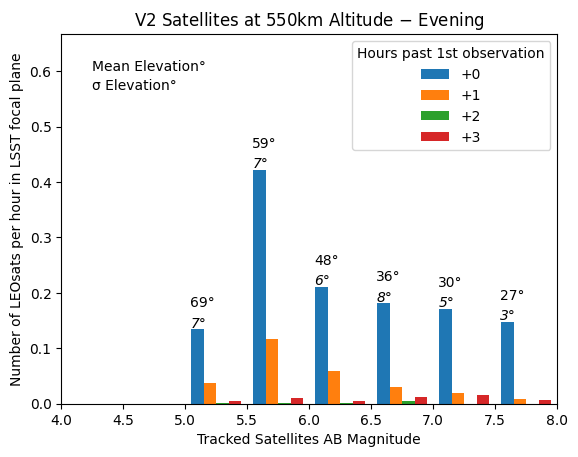

In [60]:
# Plotting a histogram for expected number of bright satellites seen by the LSST during
# an average summer night.

a = [0, 1, 2, 3, 4, 5, 6, 7, 8]
atas = []
cmap = plt.get_cmap('tab20', len(a))
colors_array = cmap(np.linspace(0, 1, len(a)))
bins = np.linspace(4, 13, 19)
hists = []
ns = []
alt_avg = []
for i in a:
    ata = dfs.loc[dfs["time_since_obs"] == i]
    hist = []
    ns.append(len(ata))
    for b in range(0, len(bins) - 1):
        ata_b = len(ata.loc[ata["ab"] > bins[b]].loc[ata["ab"] < bins[b + 1]])
        hist.append(ata_b/30)
    hists.append(hist)
xbins = []
for i in range(len(hists)):
    xbins.append(bins[:-1])
hists2 = []
for i in range(len(hists)):
    hists2.append(np.array(hists[i]) / (len(mins)))

plt.hist(xbins[0:4], bins, weights=hists2[0:4], label=["+0", "+1", "+2", "+3"])
plt.legend(title="Hours past 1st observation")
plt.xlim(4, 8)
plt.title(" ")
plt.ylabel("Number of LEOsats per hour in LSST focal plane")
plt.xlabel("Tracked Satellites AB Magnitude")
plt.ylim(0, 20/30)

for i, n in zip(xbins[0][2:-10], hists2[0][2:-10]):
    mean_alt = int(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"] > i].loc[dfs["time_since_obs"] < 4]["alts"].mean())
    mean_az = int(
        streakfunctions.first_n_digits(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"] > i].loc[dfs["time_since_obs"] < 4]["azs"].mean(), 3))
    std_alt = int(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"] > i].loc[dfs["time_since_obs"] < 4]["alts"].std())
    plt.text(i + 0.04, n + 1.2/30, str(mean_alt) + "°")
    plt.text(i + 0.04, n + 0.1/30, str(std_alt) + "°", style="italic")

plt.text(4.25, 18/30, "Mean Elevation°")
plt.text(4.25, 17/30, "σ Elevation°")
plt.title("V2 Satellites at 550km Altitude $-$ Evening")

Text(0.5, 1.0, 'V2 Satellites at 550km Altitude $-$ Morning')

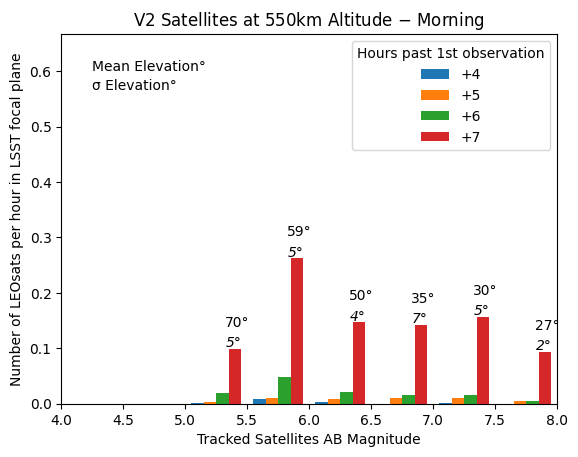

In [61]:
# Helper code for plotting the histogram of expected number of bright satellites an 
# average summer morning.

plt.hist(xbins[4:8], bins, weights=hists2[4:8], label=["+4", "+5", "+6", "+7"])
plt.legend(title="Hours past 1st observation")
plt.xlim(4,8)
plt.title(" ")
plt.ylabel("Number of LEOsats per hour in LSST focal plane")
plt.xlabel("Tracked Satellites AB Magnitude")
plt.ylim(0,20/30)

for i, n in zip(xbins[0][2:-10], hists2[7][2:-10]):
    mean_alt = int(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"]>i].loc[dfs["time_since_obs"] >= 4]["alts"].mean())
    mean_az = int(streakfunctions.first_n_digits(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"]>i].loc[dfs["time_since_obs"] < 4]["azs"].mean(),3))
    std_alt = int(dfs.loc[dfs["ab"] < i + 0.5].loc[dfs["ab"]>i].loc[dfs["time_since_obs"] >= 4]["alts"].std())
    plt.text(i+0.32, n + 1.2/30, str(mean_alt) + "°")
    plt.text(i+0.33, n + 0.1/30, str(std_alt) + "°", style="italic")


plt.text(4.25, 18/30, "Mean Elevation°")
plt.text(4.25, 17/30, "σ Elevation°")
plt.title("V2 Satellites at 550km Altitude $-$ Morning")

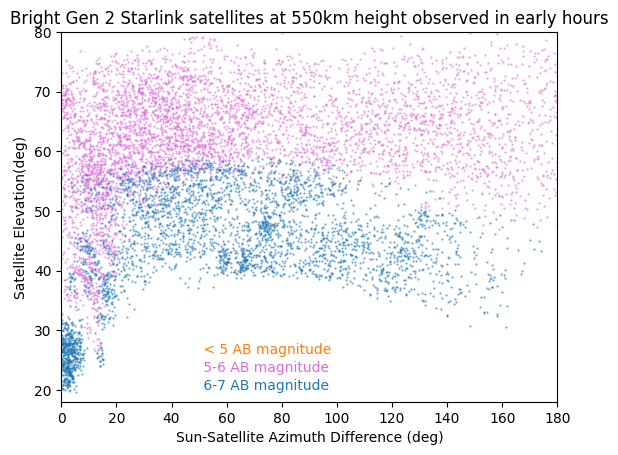

In [62]:
# Calculate the angular difference between the sun's azimuth and the satellite's azimuth
def get_az_diff(angle1, angle2):
    return min(np.abs(angle1 - angle2), 360 - np.abs(angle2 - angle1))


az_diff = np.zeros(len(dfs["azs"]))
for i in range(len(az_diff)):
    az_diff[i] = get_az_diff(dfs["azs"].iloc[i], dfs["sun_az"].iloc[i])
dfs["az_diff"] = az_diff

#Filter observations to only the observations during the first hour of the day
early_obs = dfs.loc[dfs["time_since_obs"] <= 1]

# Categorize satellites based on their brightness.
early_obs_5ab = early_obs.loc[(early_obs["ab"] <= 5)]
early_obs_6ab = early_obs.loc[(early_obs["ab"] <= 6) & (early_obs["ab"] > 5)]
early_obs_7ab = early_obs.loc[(early_obs["ab"] > 6) & (early_obs["ab"] <= 7)]

#Plotting these satellites on a scatter plot
plt.scatter(early_obs_5ab["az_diff"], early_obs_5ab["alts"], s=0.5, color="#ff7f0e", alpha=0.5)
plt.scatter(early_obs_6ab["az_diff"], early_obs_6ab["alts"], s=0.5, color="orchid", alpha=0.5)
plt.scatter(early_obs_7ab["az_diff"], early_obs_7ab["alts"], s=0.5, color="#1f77b4", alpha=0.5)
plt.xlabel("Sun-Satellite Azimuth Difference (deg)")
plt.ylabel("Satellite Elevation(deg)")
plt.ylim([18, 80])
plt.title("Bright Gen 2 Starlink satellites at 550km height observed in early hours")

plt.text(50, 26, " < 5 AB magnitude", color="#ff7f0e")
plt.text(50, 23, " 5-6 AB magnitude", color="orchid")
plt.text(50, 20, " 6-7 AB magnitude", color="#1f77b4")
plt.xlim([0, 180])
plt.show()

In [63]:
# The following functions were made Forrest Fankhauser. I have made minor changes to them
# and reimplimented them here.

def colorbar(cax, levels):
    cmap = matplotlib.colormaps['plasma_r']
    norm = matplotlib.colors.Normalize(levels[0], levels[1])
    plt.colorbar(matplotlib.cm.ScalarMappable(
        norm=norm, cmap=cmap), cax=cax, extend='both')
    cax.set_aspect(2)


def plot_compass(ax):
    ax.arrow(0, 0, 0, 0.75, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.arrow(0, 0, -0.75, 0, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.scatter([0], [0], s=30, c="black", zorder=1)
    ax.annotate("N", (0, 1.15), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.annotate("E", (-1.15, 0), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim((-1.5, 0.5))
    ax.set_ylim((-0.5, 1.5))
    ax.set_frame_on(False)
    ax.set_aspect("equal")


def contour_observer_frame(
        ax,
        altitudes,
        azimuths,
        values,
        levels=None,
        cmap='plasma'
):
    """
    Creates contour plot in observer frame

    :param ax: Matplotlib axis for plotting on
    :type ax: :class:`matplotlib.pyplot.axes`
    :param altitudes: Altitudes in HCS frame (degrees)
    :type altitudes: :class:`np.ndarray`
    :param azimuths: Azimuths in HCS frame (degrees)
    :type azimuths: :class:`np.ndarray`
    :param values: Values to plot
    :type values: :class:`np.ndarray`
    :param levels: Minimum and maximum value to plot
    :type levels: tuple, optional
    :param cmap: Matplotlib colormap to use
    :type cmap: str
    """

    if levels is None:
        levels = (4, 10)

    ax.contourf(
        np.deg2rad(azimuths),
        90 - altitudes,
        values,
        cmap=matplotlib.colormaps[cmap],
        norm=matplotlib.colors.Normalize(levels[0], levels[1]),
        levels=np.arange(levels[0], levels[1] + 1, 0.25),
        extend='both'
    )

    ax.set_rmax(90)
    ax.set_yticklabels([])
    ax.set_theta_zero_location('N')
    ax.set_rticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])
    ax.set_rlabel_position(-22.5)
    ax.grid(True)


def brightness_summary_observer_frame(
        sat_height, sun_altitudes, sun_azimuths,
        include_sun=True, include_earthshine=False,
        earth_panel_density=151, earth_brdf=earth_brdf,
        levels=(4, 10), name="Gen 2 Starlink Satellites at 550km elevation"):
    N_frames = len(sun_altitudes)

    with plt.style.context("fast"):
        fig = plt.figure(figsize=(6.4 * 2, 3.2))
        fig.suptitle(name)

        cax = fig.add_axes([0, 0.25, 0.15, 0.3])

        h = 0.8
        w = h * 6 / 32

        ax1 = fig.add_axes([0.5 - w / 2 - 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax2 = fig.add_axes([0.5 - w / 2 - 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax3 = fig.add_axes([0.5 - w / 2 + 0 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax4 = fig.add_axes([0.5 - w / 2 + 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax5 = fig.add_axes([0.5 - w / 2 + 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax6 = fig.add_axes([0.85, 0.05, 0.45 * w, 0.45 * h])

        axs = (ax1, ax2, ax3, ax4, ax5)

        plot_compass(ax6)

        sat_altitudes, sat_azimuths = \
            np.meshgrid(
                np.arange(0, 91.0, 1),
                np.arange(0, 361.0, 1))

        sat_altitudes = sat_altitudes.flatten()
        sat_azimuths = sat_azimuths.flatten()

        for ax, sun_altitude, sun_azimuth in zip(axs, sun_altitudes, sun_azimuths):
            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            sat_altitudes = sat_altitudes.flatten()
            sat_azimuths = sat_azimuths.flatten()
            calculated_intensities_reg = calculator.get_intensity_observer_frame(
                surfaces,
                np.ones(len(sat_altitudes)) * sat_height,
                sat_altitudes,
                sat_azimuths,
                sun_altitude,
                sun_azimuth,
                include_sun=True,
                include_earthshine=False,
                earth_panel_density=151,
                earth_brdf=earth_brdf
            )

            ab_magnitude = lumos.conversions.intensity_to_ab_mag(calculated_intensities_reg)
            print(ab_magnitude.mean())

            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            ab_magnitude = ab_magnitude.reshape(sat_azimuths.shape)
            # Plots intensity
            contour_observer_frame(
                ax, sat_altitudes, sat_azimuths, ab_magnitude, levels, cmap="plasma_r")

            ax.set_xticklabels(["", "", "", ""])
            ax.set_title(
                f"Sun Alt. = {sun_altitude:0.0f}°\nSun Az. = {sun_azimuth:0.0f}°")
            ax.grid(linewidth=0.5, alpha=0.25)

            ax.plot([np.deg2rad(sun_azimuth)], [101],
                    marker='$\u2600$',
                    markersize=10,
                    color="orange",
                    clip_on=False)

        colorbar(cax, levels=levels)
        cax.tick_params(labelsize=14)
        cax.set_ylabel("AB Magnitude", fontsize=16)
        cax.invert_yaxis()
        cax.yaxis.set_label_position("left")

        plt.show()

7.446102536684465
7.430560909010298
7.585752042075526
8.229225397289571
10.671371258777649


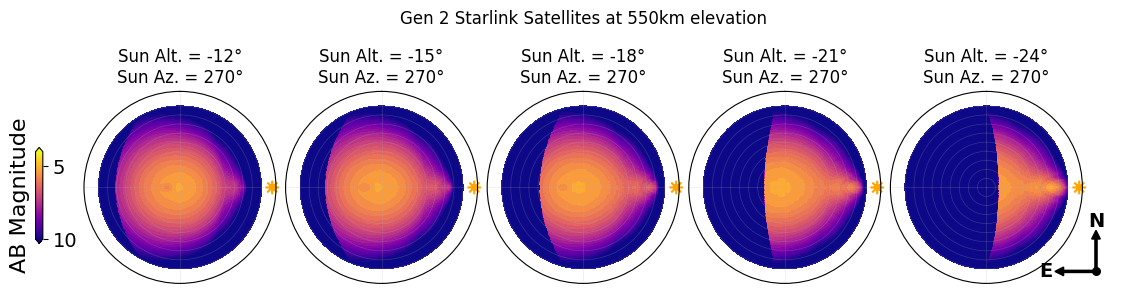

In [64]:
sat_height = 550.0 * 1000
brightness_summary_observer_frame(
    sat_height,
    [-12,-15,-18,-21,-24],
    [270., 270., 270., 270., 270.],
    include_sun=True,
    include_earthshine=False
)

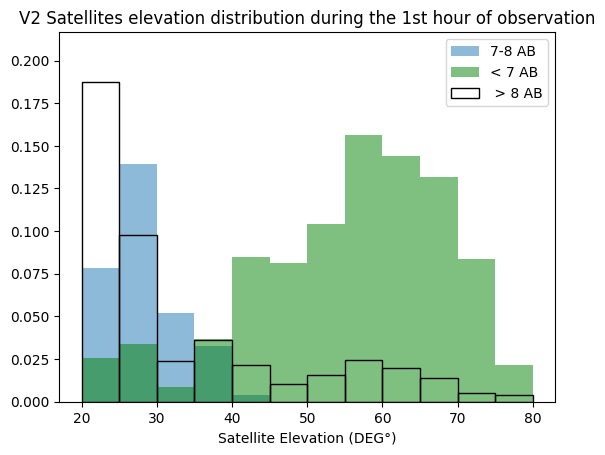

In [65]:
begs = dfs.loc[dfs["time_since_obs"] < 1]
hist, bin_edges = np.histogram(begs.loc[(begs["ab"] > 7) & (begs["ab"] < 8)]["alts"], bins=12, range=(20, 80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist / (255*30), label="7-8 AB", alpha=0.5)  #, color='#1f77b4')
hist, bin_edges = np.histogram(begs.loc[begs["ab"] < 7]["alts"], bins=12, range=(20, 80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist / (255*30), label="< 7 AB", alpha=0.5, color='green')
hist, bin_edges = np.histogram(begs.loc[begs["ab"] > 8]["alts"], bins=12, range=(20, 80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist / (255*30), label=" > 8 AB", fill=False, edgecolor='black')
plt.ylim(0, 6.5/30)
plt.title("V2 Satellites elevation distribution during the 1st hour of observation")
plt.xlabel("Satellite Elevation (DEG°)")
plt.legend()

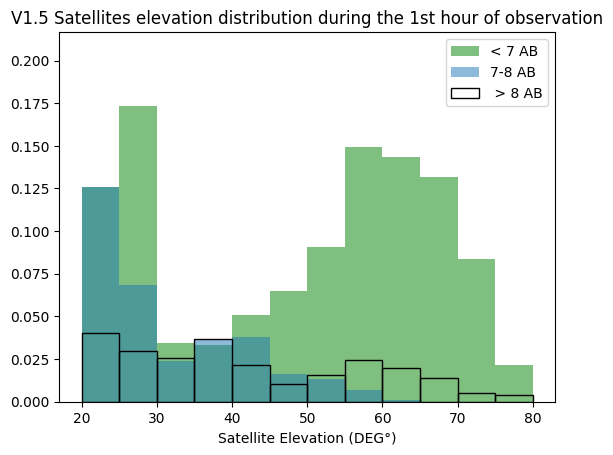

In [66]:
import satellite

intensities15 =calculator.get_intensity_observer_frame(
    satellite.SURFACES_LAB_BRDFS,
    np.array(dfs["heights"]),
    np.array(dfs["alts"]),
    np.array(dfs["azs"]),
    np.array(dfs["sun_alt"]),
    np.array(dfs["sun_az"]),
    include_sun = True,
    include_earthshine = True,
    earth_panel_density = 151,
    earth_brdf = earth_brdf
)

old_ab = lumos.conversions.intensity_to_ab_mag(intensities15)
dfs["old_ab"] = old_ab

begs = dfs.loc[dfs["time_since_obs"] < 1]
hist, bin_edges = np.histogram(begs.loc[begs["old_ab"] < 7]["alts"], bins=12, range=(20,80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist/(255*30), label = "< 7 AB", alpha=0.5, color='green')
hist, bin_edges = np.histogram(begs.loc[(begs["old_ab"] > 7) & (begs["old_ab"] < 8)]["alts"], bins=12, range=(20,80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist/(255*30), label = "7-8 AB", alpha=0.5) #, color='#1f77b4')
hist, bin_edges = np.histogram(begs.loc[begs["old_ab"] > 8]["alts"], bins=12, range=(20,80))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=hist/(255*30), label= " > 8 AB", fill=False, edgecolor='black')
plt.ylim(0,6.5/30)

plt.title("V1.5 Satellites elevation distribution during the 1st hour of observation")
plt.xlabel("Satellite Elevation (DEG°)")
plt.legend()

In [67]:
# The data/lsst_observations.py script needs to be ran for the summer schedule. 

summer0 = pd.read_csv("../data/summer_scheduler_year0/summer_schedule.csv")
summer1 = pd.read_csv("../data/summer_scheduler_year1/summer_schedule.csv")
summer2 = pd.read_csv("../data/summer_scheduler_year2/summer_schedule.csv")
summers = pd.concat([summer0, summer1, summer2]).reset_index(drop=True)
summers.set_index("observationId", inplace=True)
summers

,observationStartMJD,night,fieldRA,fieldDec,altitude,azimuth,filter,fiveSigmaDepth,note,month,hours
observationId,,,,,,,,,,,
116444,60980.125236,184,45.561358,-9.403979,54.685930,60.274360,y,21.963405,"pair_33, yy, a",11,0
116445,60980.125688,184,39.999643,-8.835501,58.417299,52.490627,y,22.016817,"pair_33, yy, a",11,0
116446,60980.126143,184,39.531275,-14.548622,62.753433,60.192382,y,22.069705,"pair_33, yy, a",11,0
116447,60980.126590,184,39.237111,-17.400959,64.828492,64.738748,y,22.097440,"pair_33, yy, a",11,0
116448,60980.127127,184,34.311396,-10.984674,64.070774,45.992201,y,22.081743,"pair_33, yy, a",11,0
...,...,...,...,...,...,...,...,...,...,...,...
621768,61802.122923,1006,60.059015,-48.816332,52.151248,227.972044,z,23.150654,DD:EDFS_a,1,23
621769,61802.123340,1006,60.059015,-48.816332,51.737864,228.122628,z,23.145850,DD:EDFS_a,1,23
621770,61802.123768,1006,60.059015,-48.816332,51.641090,228.156619,z,23.144213,DD:EDFS_a,1,23


In [69]:
tel_index = dfs["tel_index"]
filtered_df = summers.reindex(tel_index)
dfs["note"] = np.array(filtered_df["note"])


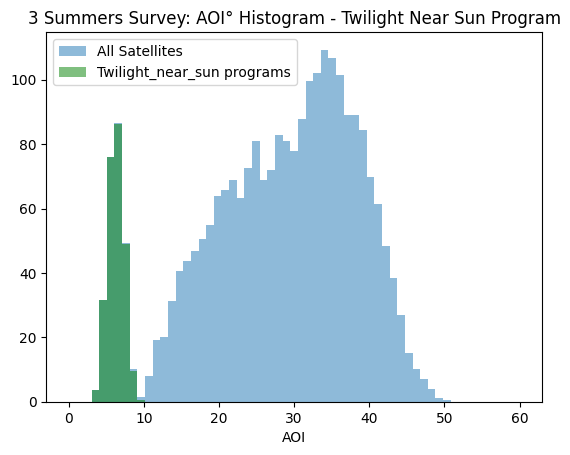

In [71]:
bins = np.linspace(0, 60, 60)
weights = np.ones_like(dfs["aoi"]) / 30
weights_note = np.ones_like(dfs.loc[(dfs["note"] == "twilight_near_sun, 0") | (dfs["note"] == "twilight_near_sun, 1") | (dfs["note"] == "twilight_near_sun, 2") | (dfs["note"] == "twilight_near_sun, 3")]["aoi"]) / 30

plt.hist(dfs["aoi"], bins=bins, weights=weights, alpha=0.5, label="All Satellites")
plt.hist(dfs.loc[(dfs["note"] == "twilight_near_sun, 0") | (dfs["note"] == "twilight_near_sun, 1") | (dfs["note"] == "twilight_near_sun, 2") | (dfs["note"] == "twilight_near_sun, 3")]["aoi"], bins=bins, weights= weights_note, alpha=0.5, color='green', label="Twilight_near_sun programs")
plt.title("3 Summers Survey: AOI° Histogram - Twilight Near Sun Program")
plt.legend()
plt.xlabel("AOI")
#plt.ylabel("Count")
plt.show()